In [ ]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Create list of all targets (minus background noise)
dataset_path = '/content/drive/MyDrive/datasets1sfinal'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
#all_targets.remove('_background_noise_')
print(all_targets)

['PawnTo']


In [ ]:
# Settings
feature_sets_path = '/content/drive/MyDrive/datasets1sfinal'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = '/content/drive/MyDrive/datasets1sfinal/wake_word_pawnto_model.h5'
wake_word = 'PawnTo'

In [ ]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [ ]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [ ]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(300, 16, 16)
(100, 16, 16)
(100, 16, 16)


In [ ]:
# Peek at labels
print(y_val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [ ]:
# Peek at labels after conversion
print(y_val)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [ ]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

1.0
0.0


In [ ]:
# View the dimensions of our input data
print(x_train.shape)

(300, 16, 16)


In [ ]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(300, 16, 16, 1)
(100, 16, 16, 1)
(100, 16, 16, 1)


In [ ]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [ ]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [ ]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [ ]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
3/3 [==============================] - 1s 103ms/step - loss: 0.7215 - acc: 0.6433 - val_loss: 0.0443 - val_acc: 1.0000
Epoch 2/30
3/3 [==============================] - 0s 37ms/step - loss: 0.0744 - acc: 0.9900 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 3/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0308 - acc: 0.9967 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 4/30
3/3 [==============================] - 0s 39ms/step - loss: 0.0152 - acc: 1.0000 - val_loss: 6.9019e-04 - val_acc: 1.0000
Epoch 5/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0122 - acc: 0.9967 - val_loss: 3.0697e-04 - val_acc: 1.0000
Epoch 6/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 1.3832e-04 - val_acc: 1.0000
Epoch 7/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 7.4149e-05 - val_acc: 1.0000
Epoch 8/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0046 - 

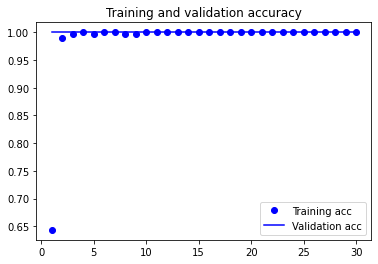

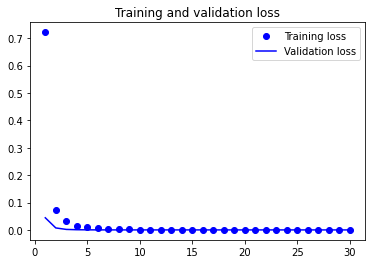

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the model as a file
models.save_model(model, model_filename)

In [ ]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(10, 20):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]


In [ ]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

4/4 [==============================] - 0s 4ms/step - loss: 8.0287e-10 - acc: 1.0000


[8.028742670695976e-10, 1.0]